# Oscars.com - Questions

Data Collection, Integration and Preprocessing

Hochschule Luzern, 2024

Master's in Applied Information and Data Science

Dominik Bacher Suarez

The following code answers Questions 2 and 4

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report

nltk.download('punkt')
nltk.download('stopwords')

pd.set_option('display.max_colwidth', 50)
pd.set_option('display.max_columns', None)

[nltk_data] Downloading package punkt to /home/student/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Analysis

In [2]:
df = pd.read_csv("../Data/Junod_Gwen_studentC_merged.csv")

## Question 2 

***“Reviews from critics exhibit distinct word usage patterns that differentiate Oscar-winning films from nominees.”***

**Research Question:** Do reviews from critics exhibit distinct word usage patterns that differentiate Oscar-winning films from nominees?

In [ ]:
df[["Critic_Review"]]

In [ ]:
def significant_words_in_reviews(df):
    def preprocess_text(text):
        # Load default English stopwords
        stop_words = set(stopwords.words('english'))
        custom_stopwords = ['movie', 'movies', 'film', 'films', 'story', 'review'] 
        stop_words.update(custom_stopwords)
        text = text.lower()
        # Create tokens
        tokens = nltk.word_tokenize(text)
        tokens = [token for token in tokens if token.isalpha()]
        tokens = [token for token in tokens if token not in stop_words]
        return tokens
    
    # Drop rows where 'Critic_Review' is NaN and ensure it's a string
    df['Critic_Review'] = df['Critic_Review'].astype(str)
    df.dropna(subset=['Critic_Review'], inplace=True)
    df['Processed_Reviews'] = df['Critic_Review'].apply(preprocess_text)
    # Create a document-term matrix
    vectorizer = CountVectorizer(analyzer=lambda x: x)  # Use the preprocessed tokens directly
    dtm = vectorizer.fit_transform(df['Processed_Reviews'])
    dtm_df = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names_out(), index=df.index)
    df.drop(columns=['Processed_Reviews'], inplace=True)

    # Separate the data into won Oscars and nominated only
    won_df = dtm_df[df['Won_Oscars']]
    nominated_df = dtm_df[~df['Won_Oscars']]
    # Calculate normalized word frequencies as percentages
    won_frequencies = won_df.sum(axis=0) / won_df.sum(axis=0).sum() * 100
    nominated_frequencies = nominated_df.sum(axis=0) / nominated_df.sum(axis=0).sum() * 100
    # Calculate the differences and find the top 20
    differences = np.abs(won_frequencies - nominated_frequencies)
    top_differences = differences.sort_values(ascending=False)
    
    return won_frequencies, nominated_frequencies, top_differences

won_frequencies, nominated_frequencies, top_differences = significant_words_in_reviews(df)

In [ ]:
%%time
top_n = 20

words_df = pd.DataFrame({
    'Won': won_frequencies[top_differences.head(top_n).index],
    'Nominated': nominated_frequencies[top_differences.head(top_n).index]
}).fillna(0)  # Fill NaN with 0 in case some words are missing in one of the categories

# Sorting by one of the columns to have a meaningful order, here by 'Won'
words_df.sort_values('Won', ascending=True, inplace=True)

# Generate the bar plot
fig, ax = plt.subplots(figsize=(8, 6))
index = np.arange(len(words_df))
bar_width = 0.35
bars1 = ax.barh(index, words_df['Won'], bar_width, label='Winner', color='#C79F27')
bars2 = ax.barh(index + bar_width, words_df['Nominated'], bar_width, label='Nominated', color='grey')
ax.set_xlabel('Normalized Term Frequency', fontsize=16)
ax.set_title('Top Words in Critics Reviews for Oscar-Winning vs Nominated Movies', fontsize=18)
ax.set_yticks(index + bar_width / 2)
ax.set_yticklabels(words_df.index, fontsize=14)
ax.legend(loc='center right', bbox_to_anchor=(1, 0.5), fontsize=14)
plt.tight_layout()
plt.show()

## Question 4

***“A predictive model based on the characteristics of the movie is able to predict if a movie will win the Oscar.”***

**Research Question:** Can we predict the Oscar winners from the 2024 nominee sample with greater than 50% accuracy?

### 1. Model Evaluation

In [3]:
# Irrelevant columns for Machine Learning
inconsistent_awards_columns = [
                'Animated Feature Film', 'Animated Short Film', 'Documentary (Feature)', 'Documentary (Short Subject)',
                'Documentary Feature Film', 'Documentary Short Film', 'Foreign Language Film', 'International Feature Film',
                'Irving G. Thalberg Memorial Award', 'Jean Hersholt Humanitarian Award', 'Live Action Short Film', 'Makeup', 
                'Makeup and Hairstyling', 'Music (Original Score)', 'Music (Original Song)', 'Production Design',
                'Short Film (Animated)', 'Short Film (Live Action)']
id_columns = ['Movie Title', 'Year', 'Oscar Ceremony Year', 'Released', 
                'imdbID', 'Rottentomatoes_URLs', 'Review_Date',]
cast_columns = ['Producer', 'Cast_And_Crew', 'Distributor','Production_Co']
data_leakage_columns = ['Oscars_Won', 'Total_Oscars_Awarded', 'Percentage of Wins',  'Awards', 'Won_Oscars']
text_columns = ['Critics_Concensus', 'Critic_Review', 'Plot']

In [4]:
# The following categories are considered for prediction
categories_for_training = ['Actor in a Leading Role', 'Actor in a Supporting Role',
       'Actress in a Leading Role', 'Actress in a Supporting Role',
       'Art Direction', 'Best Picture', 'Cinematography', 'Costume Design',
       'Directing', 'Film Editing', 'Sound', 'Sound Editing', 'Sound Mixing',
       'Visual Effects', 'Writing (Adapted Screenplay)', 'Writing (Original Screenplay)']

In [5]:
# Recalculate Won Oscar Boolean ignoring the inconsistent awards
df_ml = df.drop(columns = inconsistent_awards_columns, errors='ignore') 
def check_winner(row):
    for category in categories_for_training:
        if row.get(category) == 'Winner':
            return True
    return False

df_ml['ML_Won_Oscars'] = df_ml.apply(check_winner, axis=1)
df_ml['ML_Won_Oscars'].sample(5)

668     True
551    False
116    False
809    False
90     False
Name: ML_Won_Oscars, dtype: bool

In [6]:
# Define the Logistic Regression pipeline
def create_lr_pipeline(preprocessor, class_weight=None):
    lr_model = LogisticRegression(
        solver='liblinear',
        class_weight=class_weight,
        C=0.3,
        max_iter=1000,
        random_state=15)
    pipeline_lr = Pipeline(steps=[
                                ("pre_process", preprocessor),
                                ("model", lr_model)
                                ])
    return pipeline_lr

In [7]:
# Let's visualize the class imbalance
print(df_ml['ML_Won_Oscars'].value_counts())
percentage = df_ml['ML_Won_Oscars'].value_counts(normalize=True) * 100
print(percentage)

ML_Won_Oscars
False    728
True     123
Name: count, dtype: int64
ML_Won_Oscars
False    85.546416
True     14.453584
Name: proportion, dtype: float64


In [8]:
%%time
# Generate the training and testing data for evaluating the model
df_lr = df_ml.drop(columns= id_columns + cast_columns + data_leakage_columns + text_columns + categories_for_training, errors='ignore') 
X = df_lr.drop(columns=['ML_Won_Oscars'])
y = df_lr['ML_Won_Oscars']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20, stratify=y)
print(f"Shape of training set: {X_train.shape}. Shape of test set: {X_test.shape}")
print(f"Training set: {y_train.mean():.2%} true samples, Test set: {y_test.mean():.2%} true samples")

# Separate the categorical from the numerical columns
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = X_train.select_dtypes(include=['int', 'float']).columns.tolist()

# Pipeline for processing the data for training
categorical_transformer = Pipeline(steps=[("cat_imputer", SimpleImputer(strategy='constant',
                                                                        fill_value='Not Available').set_output(transform="pandas")),
                                          ("onehot", OneHotEncoder(sparse_output=False,
                                                                   handle_unknown="ignore").set_output(transform="pandas"))])
numeric_transformer = Pipeline(steps=[("knn_imputer", KNNImputer(n_neighbors=5).set_output(transform="pandas")),
                                      ("scaler", StandardScaler().set_output(transform="pandas"))])
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numeric_features),
                                               ("cat", categorical_transformer,categorical_features)]
                                               ).set_output(transform="pandas")
class_weight = {
    0: 1,  # false class
    1: 3}  # true class

# Create and fit the regression pipeline
pipeline_lr = create_lr_pipeline(preprocessor, class_weight)
pipeline_lr.fit(X_train, y_train)
y_pred = pipeline_lr.predict(X_test)

# Show model evaluation
print("\n")
print(classification_report(y_test, y_pred))
class_labels = pipeline_lr.named_steps['model'].classes_
display(pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=class_labels, index=class_labels))

Shape of training set: (680, 20). Shape of test set: (171, 20)
Training set: 14.41% true samples, Test set: 14.62% true samples


              precision    recall  f1-score   support

       False       0.98      0.88      0.93       146
        True       0.57      0.92      0.71        25

    accuracy                           0.89       171
   macro avg       0.78      0.90      0.82       171
weighted avg       0.92      0.89      0.90       171



,False,True
False,129,17
True,2,23


CPU times: user 375 ms, sys: 215 ms, total: 590 ms
Wall time: 191 ms


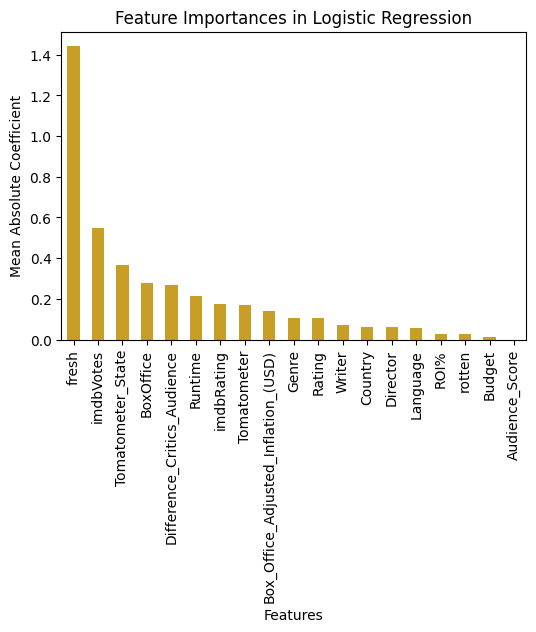

In [9]:
# Find the feature importances
lr_model = pipeline_lr.named_steps['model']
preprocessor = pipeline_lr.named_steps['pre_process']

# Get the feature names
numeric_features_list = numeric_features.copy()
categories_transformed = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
feature_names = numeric_features_list + list(categories_transformed)

# Get the coefficients for the model
coefficients = lr_model.coef_[0]
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Map transformed feature names back to original feature names since OHE transformed the naming
def find_original_feature_name(feature, original_cats):
    for original_cat in original_cats:
        if feature.startswith(original_cat + '_'):
            return original_cat
    return feature  # If it was numeric, return it as is
feature_importances['Original_Feature'] = feature_importances['Feature'].apply(
    lambda x: find_original_feature_name(x, categorical_features)
)

# Aggregate and sort the coefficients
aggregated_importances = feature_importances.groupby('Original_Feature')['Coefficient'].agg(lambda x: np.mean(np.abs(x)))
sorted_aggregated_importances = aggregated_importances.sort_values(ascending=False)

# Plot it
plt.figure(figsize=(6, 4))
sorted_aggregated_importances.plot(kind='bar', color="#C79F27")
plt.title('Feature Importances in Logistic Regression')
plt.xlabel('Features')
plt.ylabel('Mean Absolute Coefficient')
plt.show()

### 2. Final Model Training and Predictions

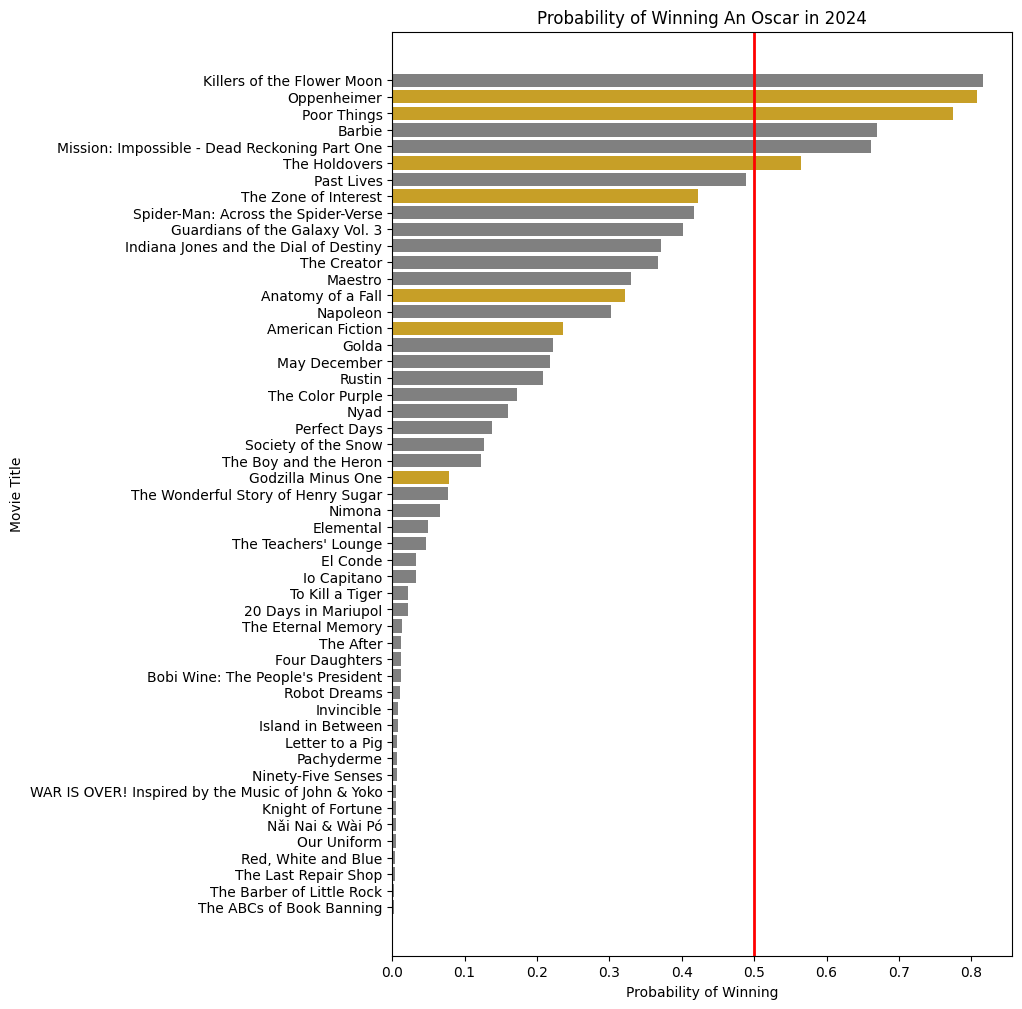

In [10]:
# Re-train the model, but this time ignoring the 2024 movies, to avoid data leakage
df_pred = df_ml[df_ml['Oscar Ceremony Year'] != 2024]
df_pred = df_pred.drop(columns= id_columns + cast_columns + data_leakage_columns + text_columns + categories_for_training, errors='ignore') 
X = df_pred.drop(columns=['ML_Won_Oscars'])
y = df_pred['ML_Won_Oscars']
pipeline_lr = create_lr_pipeline(preprocessor, class_weight)
pipeline_lr.fit(X, y)

# Select the actual winners to see how well the prediction did
df_2024 = df_ml[df_ml['Oscar Ceremony Year'] == 2024]
df_2024 = df_2024.drop(columns= id_columns + cast_columns + data_leakage_columns + text_columns + categories_for_training, errors='ignore') 
X_2024 = df_2024.drop(columns=['ML_Won_Oscars'])

# Predict probabilities of winning Best Picture
probabilities = pipeline_lr.predict_proba(X_2024)[:, 1]
df_2024['Probability of Winning'] = probabilities

# Sort DataFrame and add colors for better visual arrangement
df_2024.sort_values('Probability of Winning', ascending=True, inplace=True)
df_2024 = pd.merge(df_2024, df[["Movie Title"]], left_index=True, right_index=True)
df_2024['color'] = df_2024['ML_Won_Oscars'].apply(lambda x: '#C79F27' if x else 'gray')

# Plotting
plt.figure(figsize=(8, 12))
for i, row in df_2024.iterrows():
    plt.barh(row['Movie Title'], row['Probability of Winning'], color=row['color'])
plt.axvline(x=0.5, color='red', linestyle='-', linewidth=2)
plt.xlabel('Probability of Winning')
plt.ylabel('Movie Title')
plt.title('Probability of Winning An Oscar in 2024')
plt.show()